# Histogram Equilization

**Findings**
- my equalization is doing histogram segmentation b/c of how i'm doing the normalization - pretty much a change of scale. 
- TODO: implement proper equalization eq 

**Using Scikit**
- [Scikit docs](https://scikit-image.org/docs/dev/auto_examples/color_exposure/plot_equalize.html)
- [Wiki: Histogram Equalization](https://en.wikipedia.org/wiki/Histogram_equalization)

**Notes on Histogram Equilization**
- A method of contrast adjustment using an image's histogram (tonal distribution). Contrast is difference in brightness and/or luminance/color. 
- A global method.  The result is usually an increase in global contrast - lower contrast areas get an increase and higher contrast areas get a decrease by spreading out the most frequent intensity values. I.E. flatten the histogram using most frequent values
- Is an invertible operation 
- Suitable for images with low variation in contrast I.E. both foreground and background have same intensity. E.G.
    - x-ray images e.g. bone structure 
    - Other scientific images: thermal, satellite. Generally where you can apply pseudo-color
    - over/under exposed photos, glare,  
        - can go crazy, though e.g. add gradient. Also not as good on low color depth images b/c also makes a reduction in color depth. 
- However, it is indiscriminate and may increase contrast of background noise at expense of usable signal
    - may want to denoise/smooth prior 
  
**Histogram Equilization Methods**
- Two ways: 1). Image change 2). Palette change 
    - Palette is color look up table 
    - P palette --> M histogram eq mapping --> I image :: P(M(I))
    - Palette change = P(M) and leave image unchanged 
    - Image change = M(I) and leave palette unchanged 
- **M Histogram Eq Mapping:** Methods include 
    - local contrast emphasis: mutli-hists (subhists). Goal is to improve contrast without causing detail loss or shift in brightness
        - Adaptive Histogram Equilization (AHE)
        - Contrast Limiting AHE (CLAHE)
        - Multipeak Bihistogram Equalization (MBOBHE)
- **Back projection:** reapplication of modified histogram on to original image. Akin to an LUT for pixel brightness
- **Color Images:** to avoid affecting the relative distribution of color channels (color balance), first map onto HSI/HSL/HSV color spaces so that can operate on luminance and leave hue intact
- 

**Computation**
h(x) = [(CDF(x) - CDF_min)/(MN - CDF_min) ] *(255=2^b -1), MN=#pixels

- Linear normalization = (I - min)(New_range/range) + New_min
    - Normalization==Contrast/histogram stretching, Dynamic range expansion
- Non-linear normalization = New_range(sigmoid_fx(I)) + New_min
    - e.g. sigmoid function, 
    
- [Derivation](https://www.math.uci.edu/icamp/courses/math77c/demos/hist_eq.pdf)

In [1]:
%run "000_shared_lib.ipynb"

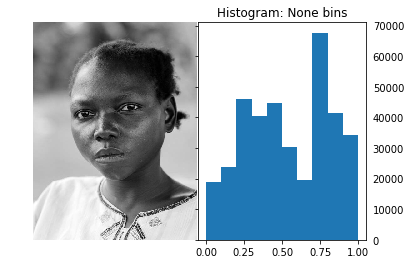

In [2]:
img = AnImage("media/img3.jpeg", True)
img.show()

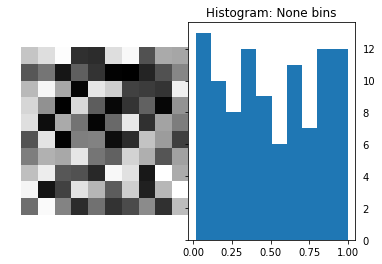

In [3]:
img2 = ArrayImage( np.random.rand(100).reshape(10,-1))
img2.show()

/home/moranis/anaconda3/lib/python3.7/site-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))


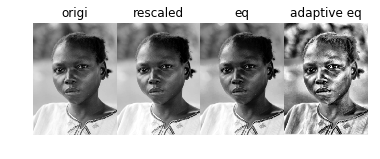

In [4]:
## clean image first b/c method may amplify noise
cimg = img.denoised(1)

## Contrast Stretching
p2, p98 = np.percentile( cimg, (1, 99) ) 
img_rescale = skimage.exposure.rescale_intensity(cimg, in_range=(p2, p98))

## equilization 
img_eq = skimage.exposure.equalize_hist(cimg) 

## adaptive equalization 
img_adeq = skimage.exposure.equalize_adapthist(cimg, clip_limit=0.03)

## plot
show_image_list([cimg, img_rescale, img_eq, img_adeq], nc=4,
               titlez=['origi', 'rescaled', 'eq', 'adaptive eq'])

In [5]:
# some math for it
def gen_hist(img, binz=10, brange=None):
    hist, bins = np.histogram(img, bins=binz, range=brange)    
    plt.hist(hist/hist.max())

def equalize_hist(img, binz=10, erange=(0,255) ):
    ## clean image required
    # 1. get histogram 
    hist, bins = np.histogram(img, bins=binz)
    hist = hist/hist.max()
    # 2. get CDF of histogram
    cum_hist = np.cumsum( hist )
    # 3. normalize each image pixel
    imin = img.min()
    imax = img.max()
    irange = imax - imin
    M, N = img.shape 
    
    nmin = np.array(erange).min()
    nmax = np.array(erange).max()
    nrange = nmax - nmin
    
    cdf_min = cum_hist.min() 
    cdf_max = cum_hist.max() 
    cdf_range = cdf_max - cdf_min
    
    norma = (cum_hist - cdf_min) * (nrange) / ( (M*N) - cdf_min)
    
    #normed =   ( (img - imin)*(cdf_range) / irange) + cdf_min 
    
    def cdf_x(x):
        d = cum_hist[ np.where( cum_hist <= x ) ]
        return d.max() if d.size > 0 else 0
        
    normed = (np.vectorize(cdf_x)(img.flatten()) - cdf_min) * (nrange) / ( (M*N) - cdf_min)
    
    # 4. plot results 
    plt.plot(hist)
    plt.plot(cum_hist)
    plt.plot(norma)
    plt.legend(['hist', 'cum_hist', 'normed'])
    plt.show()
    
    return(normed)
    

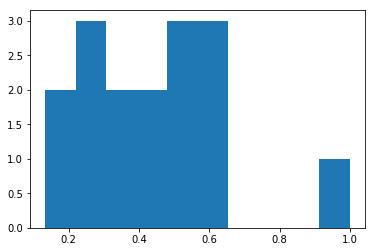

In [6]:
nimg = img.denoised(10)
nbinz= 16
gen_hist( nimg, binz=nbinz)

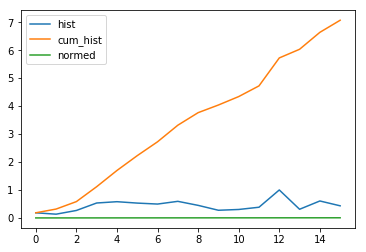

In [7]:
normed = equalize_hist(nimg, binz=nbinz)

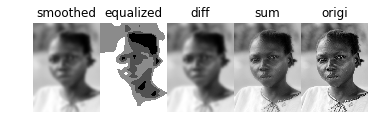

In [8]:
# nr = int( np.sqrt(normed.shape[0]) )
# show_image_list( [img.img, normed.reshape(nr, -1) ]); 

normed = normed.reshape(nimg.shape) 

show_image_list( [nimg, normed, nimg - normed, nimg+img.img, img.img], titlez=['smoothed', 'equalized', 'diff', 'sum', 'origi'], nc=5); 

In [47]:
 def make_3d(img):
    if len(img.shape) >= 3:
        return img.copy()

    nr, nc = img.shape
    f = np.empty( (nr, nc, 3))
    Lrgb = np.array([219, 1, 1])
    ##brute force
    for i in range(nr):
        for j in range(nc):
            for k in range(3):
                f[i,j,k] = img[i,j]*(k)                
    return f

In [48]:
def do_colorise(img):
    nr, nc = img.shape
    rgb_normed = make_3d(img)

    # tmp = rbg_normed.flatten()
    # tmp[ tmp > 100 ]

    #rgb_normed = rgb_normed[ rgb_normed > 100 ]

    show_image_list( [img, rgb_normed])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


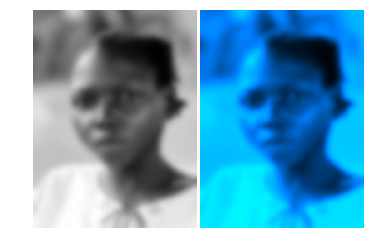

In [49]:
do_colorise(nimg)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


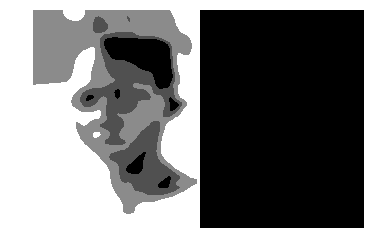

In [50]:
do_colorise(normed)